In [68]:
from shapely.geometry import Point
from functools import reduce
from faker import Faker
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import datetime
import random
import pprint
import bcrypt
import click
import time
import json
import pytz
%matplotlib inline

pp = pprint.PrettyPrinter(indent=2)

In [9]:
def sort_subreddits(filename, sort_with):
    profile_pics = {}
    with open(filename, 'r') as subreddit_file:
        subs = json.load(subreddit_file)
        for k,v in sort_with.items():
            profile_pics[k] = reduce(lambda x,y: list(set(x + subs[y])), v, [])
    return profile_pics

def sexual_orientation():
    orientation = [
        'heterosexual',
        'homosexual',
        'bisexual']
    return np.random.choice(orientation, p=[0.6, 0.2, 0.2])


In [3]:
def profile_pic_generator():
    subreddit_genders = {
        'male': ['ladyboners', 'hotguys'],
        'female': ['prettygirls', 'beautifulfemales']
    }
    profile_pics = sort_subreddits('./ladyboners_hotguys_prettygirls_beautifulfemales.json', subreddit_genders)
    length = {'male': len(profile_pics['male']),
              'female': len(profile_pics['female'])}
    counter = {'male': 0,
               'female': 0}
    def next_profile_pic(gender):
        if gender not in ['male', 'female']:
            return ''
        picture_url = profile_pics[gender][counter[gender] % length[gender]]
        counter[gender] += 1
        return picture_url
    return next_profile_pic

In [38]:
def generate_age_distribution(min_age = 18, max_age = 77, size = 1000):
    ages = 13 + 12 * np.random.lognormal(0, 0.42, size = size)
    return np.clip(ages, min_age, max_age)

def plot_distribution(dist):
    print("min:", min(dist))
    print("max:", max(dist))
    num_bins = 2 * int(max(dist) - min(dist))
    plt.hist(dist, bins = num_bins if num_bins < 420 else 420)
    plt.show()

min: 18.0
max: 54.262270924335716


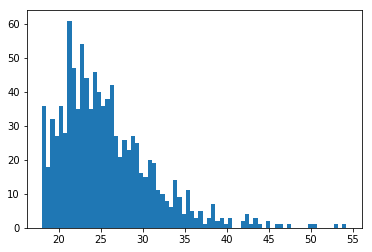

In [39]:
ages = generate_age_distribution()
plot_distribution(ages)

In [6]:
def generate_date_of_birth(min_age = 18, max_age = 77, size = 1000):
    tz = pytz.timezone('Europe/Paris')
    ages = generate_age_distribution(min_age, max_age, size)
    now = datetime.datetime.now(tz)
    dob = [(now - datetime.timedelta(days = int(366 * age))).strftime(format="%Y-%m-%d %H:%M:%S%z") for age in ages]
    return dob

In [7]:
dob = generate_date_of_birth(size=10)
print(dob)

['1986-11-13 02:42:12+0200', '1996-03-17 02:42:12+0200', '1988-03-23 02:42:12+0200', '1995-11-10 02:42:12+0200', '1996-10-11 02:42:12+0200', '1998-06-13 02:42:12+0200', '1995-11-10 02:42:12+0200', '1997-03-13 02:42:12+0200', '1990-03-24 02:42:12+0200', '1992-08-12 02:42:12+0200']


min: 3.9236105945031574
max: 3467.839595239004


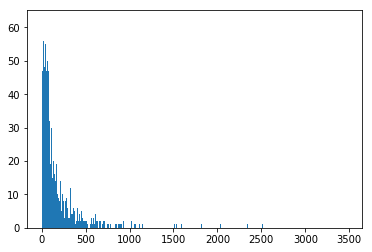

In [62]:
def generate_minutes_distribution(size = 1000):
    minutes = 100 * np.random.lognormal(0, 1.2, size = size)
    return minutes

plot_distribution(generate_minutes_distribution())

In [63]:
def generate_last_seen(size = 1000):
    tz = pytz.timezone('Europe/Paris')
    minutes = generate_minutes_distribution(size = size)
    now = datetime.datetime.now(tz)
    last_seen = [(now - datetime.timedelta(seconds = int(60 * minute))).strftime(format="%Y-%m-%d %H:%M:%S%z") for minute in minutes]
    return last_seen

In [85]:
def generate_fake_profiles(size = 1000):
    start = time.time()
    fake = Faker('fr_FR')
    next_profile_pic = profile_pic_generator()
    hashed_password = bcrypt.hashpw("auie", bcrypt.gensalt(10))
    profiles = []
    
    for _ in tqdm(range(size)):
        profile = fake.profile()
        profile['hashed_password'] = hashed_password
        name = profile['name'].split(' ')
        profile['firstname'] = name[0]
        profile['lastname'] = ' '.join(name[1:])
        profile['gender'] = 'male' if profile['sex'] == 'M' else 'female'
        profile['sexual_orientation'] = sexual_orientation()
        profile['bio'] = fake.text(max_nb_chars = 200)
        profile['num_pics'] = 1
        profile['url_pp'] = next_profile_pic(profile['gender'])
        profile['email'] = profile['mail']
        lon, lat = fake.local_latlng(country_code="FR", coords_only=True)
        profile['position'] = Point((float(lon),float(lat)))
        profile['popularity_score'] = random.randrange(100)
        profile['verified'] = True
        profile.pop('mail')
        profile.pop('birthdate')
        profile.pop('blood_group')
        profile.pop('address')
        profile.pop('company')
        profile.pop('job')
        profile.pop('name')
        profile.pop('residence')
        profile.pop('sex')
        profile.pop('ssn')
        profile.pop('website')
        profile.pop('current_location')
        profiles.append(profile)
        
    df = pd.DataFrame(profiles)
    df['date_of_birth'] = generate_date_of_birth(min_age = 18, max_age = 77, size = size)
    df['last_seen'] = generate_last_seen(size = size)
    original_length = len(df)
    df = df.drop_duplicates(['email', 'username'])
    num_duplicated = original_length - len(df)
    if (num_duplicated):
        print("dropped {} row(s) (duplicated email or username)".format(num_duplicated))
    crs = {'init': 'epsg:4326'}
    return gpd.GeoDataFrame(df, crs=crs, geometry='position')


In [86]:
df = generate_fake_profiles(size = 1000)

100%|██████████| 1000/1000 [00:06<00:00, 145.09it/s]


In [87]:
df.head()

,bio,email,firstname,gender,hashed_password,lastname,num_pics,popularity_score,position,sexual_orientation,url_pp,username,verified,date_of_birth,last_seen
0,Projet précieux commencer absolument fait jeun...,victor16@tele2.fr,Zacharie,male,$2a$10$Bkz/K4leilRjPBfCOrmPYe4fHN6ZIojMuWWJidW...,Antoine,1,73,POINT (43.61092 3.87723),heterosexual,http://i.imgur.com/MQubKaT.jpg,roger61,True,1990-06-04 03:29:42+0200,2019-05-09 03:10:51+0200
1,Général projet appartement prendre. Quart avou...,olivier95@hotmail.fr,Paul,male,$2a$10$Bkz/K4leilRjPBfCOrmPYe4fHN6ZIojMuWWJidW...,Dumas,1,44,POINT (44.92801 4.8951),heterosexual,https://i.imgur.com/WYPsmPG.jpg,louise27,True,1994-10-10 03:29:42+0200,2019-05-09 02:08:39+0200
2,Achever cou complet clef françois enlever situ...,dhebert@noos.fr,Corinne,female,$2a$10$Bkz/K4leilRjPBfCOrmPYe4fHN6ZIojMuWWJidW...,Laporte de la Descamps,1,8,POINT (44.92801 4.8951),heterosexual,https://i.imgur.com/HXe5bGQ.jpg,inesseguin,True,1992-11-10 03:29:42+0200,2019-05-08 23:55:45+0200
3,Volonté beauté fumer expression commun intenti...,gimenezmartin@tele2.fr,Eugène,male,$2a$10$Bkz/K4leilRjPBfCOrmPYe4fHN6ZIojMuWWJidW...,Julien,1,44,POINT (45.69558 4.7934),heterosexual,https://40.media.tumblr.com/293f23fbee6d48493d...,luce17,True,1980-11-20 03:29:42+0200,2019-05-09 02:23:19+0200
4,Contre attirer ciel maintenir pendre vouloir c...,emilie71@gmail.com,Michèle,female,$2a$10$Bkz/K4leilRjPBfCOrmPYe4fHN6ZIojMuWWJidW...,Louis-Raynaud,1,44,POINT (48.90472 2.2469),bisexual,http://i.imgur.com/6fSD00e.jpg,cthierry,True,1997-06-04 03:29:42+0200,2019-05-09 02:40:54+0200


In [88]:
df.to_csv("fake_profiles.csv", sep = ';', index = False)